# Тестовое задание #1 на позиции Data Analyst и Data Scientist

## 1. Загрузка данных

Импорт необходимых пакетов

In [143]:
import io
import sys
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as smm
from matplotlib.lines import Line2D
from scipy import stats
from statsmodels.stats.weightstats import zconfint
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Загрузим данные из файла 'product_info.csv', преобразуем их в два датафрейма.

In [144]:
PATH_TO_PRODUCT_INFO = 'product_info.csv'
PATH_TO_REFUSED_PRODUCTS = 'refused_order_products.csv'

Данные по семенам и фабричным продуктам:

In [145]:
with open(PATH_TO_PRODUCT_INFO) as file:
    seed_ended = False
    seed_contents = []
    prod_contents = []
    
    for line in file:
        line = line.strip()
    
        if not line:
            seed_ended = True
            continue
    
        if line in ['Семена', 'Товары с фабрик']:
            continue
    
        if seed_ended:
            prod_contents.append(line)
        else:
            seed_contents.append(line)
    
    seed_contents = '\n'.join(seed_contents)
    prod_contents = '\n'.join(prod_contents)

seed_df = pd.read_csv(io.StringIO(seed_contents), sep='\t')
prod_df = pd.read_csv(io.StringIO(prod_contents), sep='\t')

Данные по отказам:

In [146]:
with open(PATH_TO_REFUSED_PRODUCTS) as file:
    data = []
    prod_id_bag = []

    line_pair = []

    for line in file:
        line = line.strip()

        if line.startswith(',,,'):
            continue

        line_pair.append(line)
        if len(line_pair)<2:
            continue

        header_segs = line_pair[0].split(',')
        count_segs  = line_pair[1].split(',')

        lvl = count_segs[0]
        data_line = [lvl] + [0]*len(prod_id_bag)

        for prod_id, cnt in zip(header_segs[1:], count_segs[1:]):
            if not prod_id:
                continue
            dd = prod_id
            prod_id = prod_id.strip()[9:-1]
            cnt = 0 if cnt=='' or cnt=='\n' else int(cnt)
            prod_id_idx = None
            if prod_id in prod_id_bag:
                prod_id_idx = prod_id_bag.index(prod_id)
                data_line[prod_id_idx+1] = cnt
            else:
                prod_id_idx = len(prod_id_bag)
                prod_id_bag.append(prod_id)
                data_line.append(cnt)

        data.append(data_line)

        line_pair = []

refs_df = pd.DataFrame(data, columns=['lvl']+prod_id_bag)
refs_df.fillna(0, inplace=True)

Соберем три таблицы в одну: первые две просто объединим, заменив имя колонки времени производства на 'Время производства(мин)', а вторую объединим с ними по признаку 'id_product'.

Также добавим еще две переменные: **'Тип'** (**1** - семена, **2** - фабричный продукт), **'lvl_all'** - сумма отказов по всем уровням игры.

In [147]:
seed_df.rename(columns={'Время роста(мин)': 'Время производства(мин)'}, inplace=True)

full_df = pd.concat([seed_df, prod_df], axis=0)
full_df.reset_index(drop=True, inplace=True)
full_df['Тип'] = [1]*len(seed_df) + [2]*len(prod_df)

refs_df = refs_df.set_index('lvl').T \
                 .rename_axis('id_product') \
                 .rename_axis(None, 1) \
                 .reset_index()

lvl_cols  = ['lvl_10-12', 'lvl_13-15', 'lvl_16-19', 'lvl_20-23', 'lvl_24-28', 'lvl_29-33']
feat_cols = ['Уровень ввода', 'Время производства(мин)', 'Стоимость продажи из амбара', 'Стоимость покупки за кэш', 'Тип']
refs_df.columns = ['id_product'] + lvl_cols

full_df = full_df.merge(refs_df, on=['id_product'], how='left')
full_df.dropna(inplace=True)  # 6 продуктов без данных удаляются, 92 остаются

full_df[lvl_cols] = full_df[lvl_cols].astype(int)
full_df['lvl_all'] = full_df[lvl_cols].sum(axis=1).values

In [148]:
full_df.head(10)

,Название,id_product,Уровень ввода,Время производства(мин),Стоимость продажи из амбара,Стоимость покупки за кэш,Тип,lvl_10-12,lvl_13-15,lvl_16-19,lvl_20-23,lvl_24-28,lvl_29-33,lvl_all
0,Пшеница,wheat,1,2,1,1,1,19202,21255,38051,40604,39953,40283,199348
1,Кукуруза,corn,3,5,3,1,1,22175,24127,41178,45916,49744,50945,234085
2,Морковь,carrot,4,10,5,2,1,21901,24806,44902,50207,54358,55710,251884
3,Тыква,pumpkin,6,25,6,3,1,93,74,128,98,106,66,565
4,Тростник,sugarcane,7,20,7,3,1,21218,23151,40298,44859,45788,46933,222247
5,Хлопок,cotton,9,30,9,4,1,20678,22314,40889,46126,49100,50005,229112
6,Клубника,strawberry,13,60,11,5,1,159,20923,39983,39649,41308,41587,183609
7,Томат,tomat,15,120,13,6,1,0,7160,40374,43517,43888,42706,177645
8,Елка,pine,18,180,15,7,1,0,2,20925,44090,43274,42057,150348
9,Картофель,potato,22,240,17,8,1,1,1,5,19969,44346,42736,107058


# 2. Визуализация

Представление данных в плоскости (**'Время производства(мин)'**, **'Стоимость покупки за кэш'**).
Справа - то же в логарифмическом масштабе

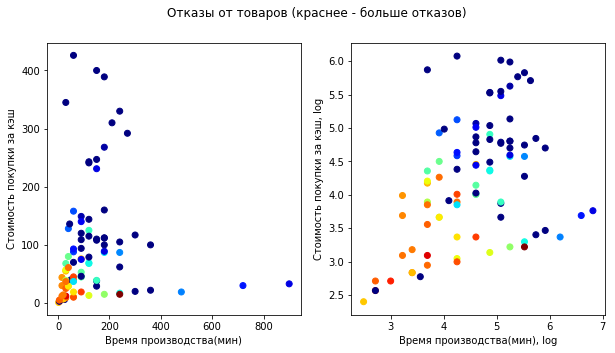

In [149]:
xx = full_df['Время производства(мин)'].values
yy = full_df['Стоимость продажи из амбара'].values

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(xx, yy, c = full_df['lvl_all'], cmap='jet')
axes[0].set_xlabel('Время производства(мин)')
axes[0].set_ylabel('Стоимость покупки за кэш')
axes[1].scatter(np.log(xx + 10), np.log(yy + 10), c = full_df['lvl_all'], cmap='jet')
axes[1].set_xlabel('Время производства(мин), log')
axes[1].set_ylabel('Стоимость покупки за кэш, log')
plt.suptitle('Отказы от товаров (краснее - больше отказов)')

plt.show()

Видим, что наиболее отказные продукты находятся в основном в области малых цен и малого времени производства 

Визуализируем тренды - зависимости количества отказов от уровня игры для каждого продукта.
Выделим градиентом свойство **'Стоимость покупки за кэш'** - чем она больше, тем график краснее, чем ниже - тем синее.
То же самое сделаем для свойства **'Время производства(мин)'** - чем оно больше, тем график краснее, чем ниже - тем синее.

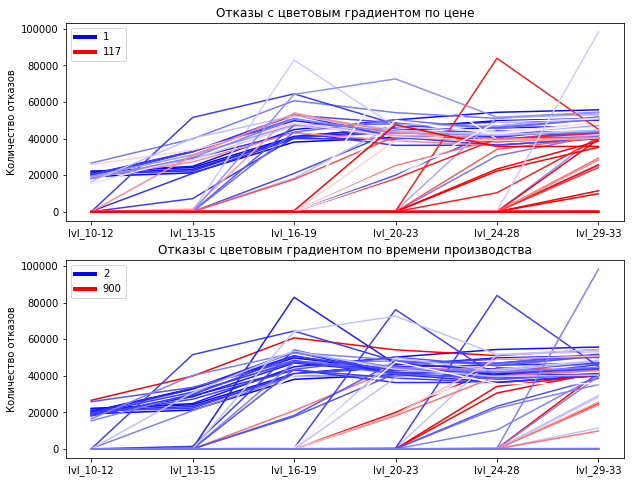

In [150]:
min_price = full_df['Стоимость покупки за кэш'].min()
max_price = full_df['Стоимость покупки за кэш'].max()
min_time  = full_df['Время производства(мин)'].min()
max_time  = full_df['Время производства(мин)'].max()

fig, axes = plt.subplots(2, 1, figsize=(10,8))
axes[0].set_title('Отказы с цветовым градиентом по цене')
axes[0].set_ylabel('Количество отказов')
legend_lines = [Line2D([0], [0], color=plt.cm.bwr(0), lw=4),
                Line2D([0], [0], color=plt.cm.bwr(700), lw=4)]
axes[0].legend(legend_lines, [min_price, max_price])
axes[1].set_title('Отказы с цветовым градиентом по времени производства')
axes[1].set_ylabel('Количество отказов')
legend_lines = [Line2D([0], [0], color=plt.cm.bwr(0), lw=4),
                Line2D([0], [0], color=plt.cm.bwr(1000), lw=4)]
axes[1].legend(legend_lines, [min_time, max_time])

for i, row in full_df.iterrows():
    price = row['Стоимость покупки за кэш']
    price_color_idx = int(700*(price - min_price)/(max_price - min_price))
    axes[0].plot(lvl_cols, row[lvl_cols].values, color=plt.cm.bwr(price_color_idx))

    time  = row['Время производства(мин)']
    time_color_idx = int(1000*(time - min_time)/(max_time - min_time))
    axes[1].plot(lvl_cols, row[lvl_cols].values, color=plt.cm.bwr(time_color_idx))

plt.show()

Видим, что в целом прослеживается ряд закономерностей:
1. В среднем на каждом диапазоне уровней игры более отказными являются более дешевые и более быстродобываемые продукты
2. Прослеживаются некоторые паттерны в трендах отказов от продуктов: какие-то тренды всегда возрастают, какие-то имеют ярко выраженный максимум

Посмотрим на зависимости исходных признаков **'Уровень ввода'**, **'Время производства(мин)'**, **'Стоимость продажи из амбара'**, **'Стоимость покупки за кэш'**, **'Тип'**
от целевой переменной **'lvl_all'** - суммы отказов по всем уровням игры

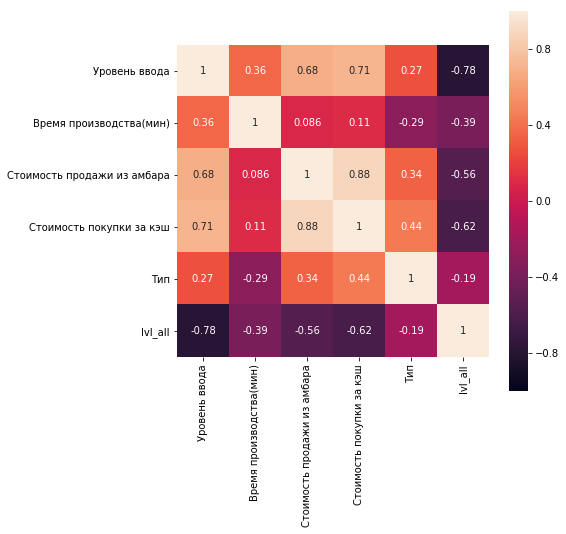

In [151]:
cols = feat_cols + ['lvl_all']
corr_coeffs = full_df[cols].corr()

fig, ax = plt.subplots(figsize=(7, 7)) 
sns.heatmap(corr_coeffs, vmin=-1, vmax=1, ax=ax, square=True, annot=True)
plt.show()

Видим, что в целом прослеживается ряд закономерностей:
1. Целевая переменная **'lvl_all'** показывает сильную корреляцию с ценами и неплохую корреляцию со временем производства.
2. Ценовые признаки сильно коррелируют, что впоследствии может сказаться на качестве алгоритмов из-за эффекта мультиколлинеарности.
3. Корреляция целевой переменной **'lvl_all'** с типом продукта (семена/фабричный) скорее всего не значима
4. Корреляция целевой переменной **'lvl_all'** с уровнем ввода очень велика, что довольно естественно и мало что объясняет (чем выше уровень ввода, тем меньше продукт в игре вплоть до его отсутствия в начале игры)

# 3. Проверка гипотез

Постараемся проверить состоятельность гипотез о связи количества отказов от цен на продукты и времени их производства.

In [152]:
sorted_df = full_df.sort_values('lvl_all', ascending=False)

sorted_df.head()

,Название,id_product,Уровень ввода,Время производства(мин),Стоимость продажи из амбара,Стоимость покупки за кэш,Тип,lvl_10-12,lvl_13-15,lvl_16-19,lvl_20-23,lvl_24-28,lvl_29-33,lvl_all
20,Wool,wool,10,240,15,11,2,26584,39812,60705,54170,51018,54347,286636
28,Pop Corn,popcorn,14,30,12,6,2,14,51533,64446,47860,46821,51794,262468
2,Морковь,carrot,4,10,5,2,1,21901,24806,44902,50207,54358,55710,251884
78,Paper,paper,18,90,19,13,2,1,9,64175,72611,51621,54231,242648
68,Shirt,shirt,12,60,45,17,2,16420,40161,52480,44688,41894,44723,240366


Для проверки гипотез нам потребуются следующие функции:

Доверительные интервалы по **z-критерию** и с помощью **bootstrap**

In [153]:
def mean_z_conf_interval(sample, caption, alpha=0.05):
    z_conf_int = zconfint(sample)
    perc = int(100*(1-alpha))
    print('{3}% доверительный Z-интервал для среднего "{0}": [{1}, {2}]'.format(caption, z_conf_int[0], z_conf_int[1], perc))
    return


def bootstrap_conf_interval(sample, caption, func, alpha=0.05, n_samples=1000):
    sample_stats = list(map(func, get_bootstrap_samples(sample, n_samples)))
    perc = int(100*(1-alpha))
    conf_int = stat_intervals(sample_stats, alpha)
    print('{3}% доверительный Bootstrap-интервал для {0}: [{1}, {2}]'.format(caption, conf_int[0], conf_int[1], perc))
    return


def get_bootstrap_samples(data, n_samples, seed=84):
    np.random.seed(seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Тест на нормальность (Q-Q график и критерий Шапиро-Уилка):

In [154]:
def normality_test(samples, captions):
    n = len(samples)
    k = int(math.sqrt(n)) + 1
    m = n//k
    i = 0
    fig, axes = plt.subplots(m, k, figsize=(10, 8))
    plt.suptitle('Q-Q тест')

    for sample, caption in zip(samples, captions):
        if i>=n:
            break
        ax = axes[i] if m==1 else axes[i//m][i%m]
        stats.probplot(sample, dist="norm", plot=ax)
        ax.set_title(caption)
        i += 1
  
        res = stats.shapiro(sample)
        print('Тест на нормальность Шапиро-Уилка для "{0}":'.format(caption), res)

    plt.show()

    return

Итак, приступим.

Мы видим, что Q-Q тест и критерий Шапиро-Уилка отвергли гипотезу о нормельности, так что использование t-критериев Стьюдента не вполне обоснованно. Тем не менее, t-критерий Стьюдента **уверенно отвергает гипотезу о равенстве средних для TOP-10 отказных и остальных товаров**.

Более того, доверительные интервалы, построенные с помощью bootstrap, **существенно отдалены друг от друга**.

### 3.1 Гипотеза 1:   Топ-10 отказных продуктов в среднем дешевле остальных по стоимости покупки за кэш

Проверим гипотезу о равенстве средних значений признака **'Стоимость покупки за кэш'**.


**Основная гипотеза**:       $H_0$ = {средние в sample1 и sample2 одинаковы}

**Альтернативные**: $H_1$ = двусторонняя (отрицание $H_0$) и односторонняя { среднее в TOP-10 < среднее у остальных }

Будем пользоваться t-критерием Стьюдента

Тест на нормальность Шапиро-Уилка для "top-10 отказные продукты": (0.9285334944725037, 0.4336237907409668)
Тест на нормальность Шапиро-Уилка для "остальные продукты": (0.9213035702705383, 9.006049367599189e-05)


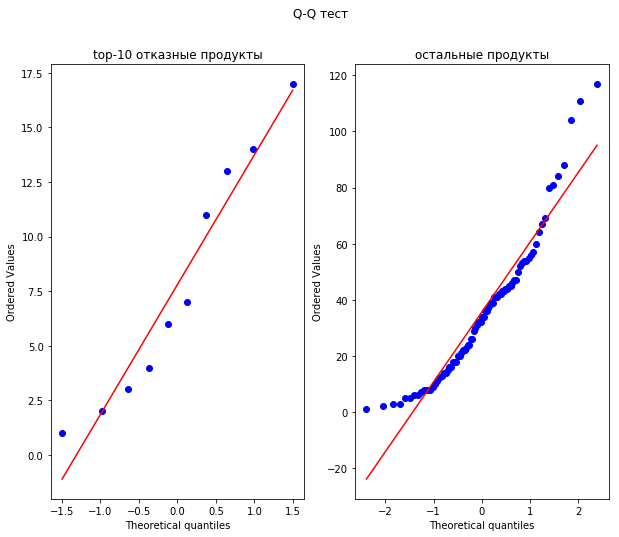

95% доверительный Z-интервал для среднего "top-10 отказные продукты": [4.333085259024378, 11.266914740975622]
95% доверительный Z-интервал для среднего "остальные продукты": [30.104168028472976, 41.115344166648974]
95% доверительный Bootstrap-интервал для среднего "top-10 отказные продукты": [4.6, 11.2]
95% доверительный Bootstrap-интервал для среднего "остальные продукты": [30.547560975609755, 41.34298780487805]
95% доверительный Bootstrap-интервал для медианы "top-10 отказные продукты": [3.0, 13.0]
95% доверительный Bootstrap-интервал для медианы "остальные продукты": [25.0, 41.0]
Критерий Стьюдента для двусторонней альтернативы: p_value 5.96298547394e-12
Критерий Стьюдента для односторонней альтернативы: p_value 1.19259709479e-11
НУЛЕВАЯ ГИПОТЕЗА о равенстве средних отвергается против двусторонней альтернативы
НУЛЕВАЯ ГИПОТЕЗА о равенстве средних отвергается против односторонней альтернативы


In [155]:
top10_prices = sorted_df.iloc[:10, :]['Стоимость покупки за кэш'].values
least_prices = sorted_df.iloc[10:, :]['Стоимость покупки за кэш'].values

# Сначала проверим нормальность выборок
normality_test([top10_prices, least_prices], ['top-10 отказные продукты', 'остальные продукты'])

# Посчитаем доверительные интервалы для средних с помощью Z-критерия и
# (так как это Z-критерий в данном случае не совсем обоснован) с помощью бутстрепа
mean_z_conf_interval(top10_prices, 'top-10 отказные продукты')
mean_z_conf_interval(least_prices, 'остальные продукты')

bootstrap_conf_interval(top10_prices, 'среднего "top-10 отказные продукты"', np.mean)
bootstrap_conf_interval(least_prices, 'среднего "остальные продукты"', np.mean)

# Посчитаем доверительные интервалы для медиан с помощью бутстрепа
bootstrap_conf_interval(top10_prices, 'медианы "top-10 отказные продукты"', np.median)
bootstrap_conf_interval(least_prices, 'медианы "остальные продукты"', np.median)

# Гипотеза о равенстве средних
p_value = stats.ttest_ind(top10_prices, least_prices, equal_var = False)[1]
print('Критерий Стьюдента для двусторонней альтернативы: p_value', p_value)
print('Критерий Стьюдента для односторонней альтернативы: p_value', p_value*2)

print('НУЛЕВАЯ ГИПОТЕЗА о равенстве средних {0} против двусторонней альтернативы'.format('отвергается' if p_value < 0.05 else 'не отвергается'))
print('НУЛЕВАЯ ГИПОТЕЗА о равенстве средних {0} против односторонней альтернативы'.format('отвергается' if p_value < 0.05*2 else 'не отвергается'))


В данном случае Q-Q тест дает похожие на нормальные квантили, однако, критерий Шапиро-Уилка опять отвергает гипотезу о нормальности. Тем не менее, t-критерий Стьюдента **уверенно отвергает гипотезу о равенстве средних для TOP-10 отказных и остальных товаров**.

Доверительные интервалы, построенные с помощью bootstrap, также **существенно отдалены друг от друга**.

Для случая признака **'Стоимость продажи из амбара'** получаются похожие рещультаты в силу сильной коррелированности этих признаков.

### 3.2 Гипотеза 2:   У Топ-10 отказных продуктов время производства в среднем меньше, чем у остальных

Действуем аналогично

Тест на нормальность Шапиро-Уилка для "top-10 отказные продукты": (0.7072557806968689, 0.0010786792263388634)
Тест на нормальность Шапиро-Уилка для "остальные продукты": (0.7053358554840088, 1.545631331256736e-11)


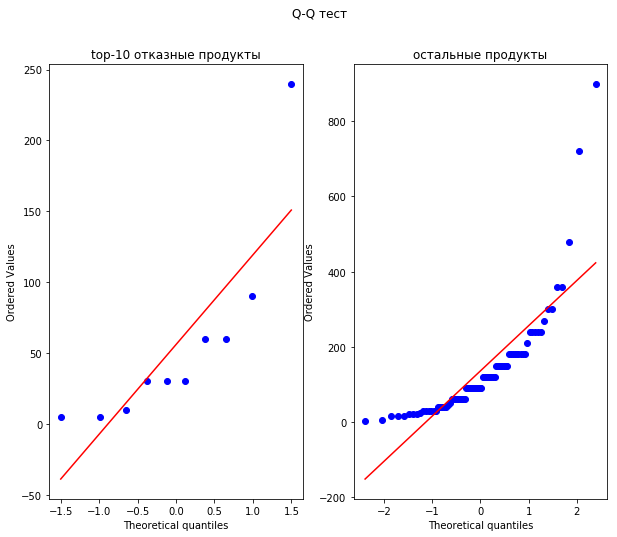

95% доверительный Z-интервал для среднего "top-10 отказные продукты": [12.471930250493372, 99.52806974950663]
95% доверительный Z-интервал для среднего "остальные продукты": [105.15350478164424, 166.60259277933136]
95% доверительный Bootstrap-интервал для среднего "top-10 отказные продукты": [22.5, 105.01249999999999]
95% доверительный Bootstrap-интервал для среднего "остальные продукты": [106.78658536585367, 164.81920731707316]
95% доверительный Bootstrap-интервал для медианы "top-10 отказные продукты": [10.0, 60.0]
95% доверительный Bootstrap-интервал для медианы "остальные продукты": [75.0, 120.0]
Критерий Стьюдента для двусторонней альтернативы: p_value 0.00822589890336
Критерий Стьюдента для односторонней альтернативы: p_value 0.0164517978067
НУЛЕВАЯ ГИПОТЕЗА о равенстве средних отвергается против двусторонней альтернативы
НУЛЕВАЯ ГИПОТЕЗА о равенстве средних отвергается против односторонней альтернативы


In [156]:
top10_prices = sorted_df.iloc[:10, :]['Время производства(мин)'].values
least_prices = sorted_df.iloc[10:, :]['Время производства(мин)'].values

# Сначала проверим нормальность выборок
normality_test([top10_prices, least_prices], ['top-10 отказные продукты', 'остальные продукты'])

# Посчитаем доверительные интервалы для средних с помощью Z-критерия и
# (так как это Z-критерий в данном случае не совсем обоснован) с помощью бутстрепа
mean_z_conf_interval(top10_prices, 'top-10 отказные продукты')
mean_z_conf_interval(least_prices, 'остальные продукты')

bootstrap_conf_interval(top10_prices, 'среднего "top-10 отказные продукты"', np.mean)
bootstrap_conf_interval(least_prices, 'среднего "остальные продукты"', np.mean)

# Посчитаем доверительные интервалы для медиан с помощью бутстрепа
bootstrap_conf_interval(top10_prices, 'медианы "top-10 отказные продукты"', np.median)
bootstrap_conf_interval(least_prices, 'медианы "остальные продукты"', np.median)

# Гипотеза о равенстве средних
p_value = stats.ttest_ind(top10_prices, least_prices, equal_var = False)[1]
print('Критерий Стьюдента для двусторонней альтернативы: p_value', p_value)
print('Критерий Стьюдента для односторонней альтернативы: p_value', p_value*2)

print('НУЛЕВАЯ ГИПОТЕЗА о равенстве средних {0} против двусторонней альтернативы'.format('отвергается' if p_value < 0.05 else 'не отвергается'))
print('НУЛЕВАЯ ГИПОТЕЗА о равенстве средних {0} против односторонней альтернативы'.format('отвергается' if p_value < 0.05*2 else 'не отвергается'))


Здесь все хуже с точки зрения предположения о нормальности выборок, однако, и здесь имеем **гипотеза о равенстве средних для TOP-10 отказных и остальных товаров отвергается** (по крайней мере для бутстреп оценок для доверительных интервалов средних)

### 3.3 Множественная проверка Гипотезы 2 для всех интервалов уровней с поправкой Холма

Проверим теперь гипотезу о равенстве средних значений признака **'Стоимость покупки за кэш'**, однако, не для суммарного целевого признака **'lvl_all'**, а для всех уровней. При этом мы должны сделать поправки на множестввенную проверку гипотез, чтобы получить статистически значимые результаты. 

In [157]:
n = len(lvl_cols)
p_values = np.zeros((n,))
refused_lvls = {}
for i, col in enumerate(lvl_cols):
    sorted_df = full_df.sort_values(col, ascending=False)
    for refused in sorted_df['Название'].iloc[:10].values:
        refused_lvls[refused] = refused_lvls[refused]+1 if refused in refused_lvls else 1
    top10_prices = sorted_df.iloc[:10, :]['Стоимость покупки за кэш'].values
    least_prices = sorted_df.iloc[10:, :]['Стоимость покупки за кэш'].values
    p_value = stats.ttest_ind(top10_prices, least_prices, equal_var = False)[1]
    p_values[i] = p_value
top10_lvls_refused = list(zip(*sorted(refused_lvls.items(), key=lambda kv: kv[1], reverse=True)[:10]))[0]

reject, p_normal_corr, a1, a2 = smm.multipletests(p_values, alpha=(0.05/n), method='holm')
print('Мультитест:', p_values)
print('ОТВЕРГНУТО НУЛЕВЫХ ГИПОТЕЗ: {0} из {1}'.format(sum(p_values<(0.05/n)), n))

Мультитест: [  2.90992724e-09   9.92863349e-06   4.32676765e-05   3.28488341e-08
   1.21247610e-04   1.26664640e-08]
ОТВЕРГНУТО НУЛЕВЫХ ГИПОТЕЗ: 6 из 6


Итого: **гипотезы о равенстве средних уверенно отвергаются** для всех уровней игры в совокупности.

Мы получили TOP-10 отказных продуктов по сумме всех отказов и TOP-10 продуктов по отказам на каждом уровне:

In [158]:
top10_refused = full_df.sort_values('lvl_all', ascending=False).iloc[:10]
top10_lvls_refused = list(zip(*sorted(refused_lvls.items(), key=lambda kv: kv[1], reverse=True)[:10]))[0]

print(top10_refused['Название'].values)
print(top10_lvls_refused)

['Wool' 'Pop Corn' 'Морковь' 'Paper' 'Shirt' 'Egg' 'Кукуруза' 'Bread'
 'Cheese' 'Хлопок']
('Wool', 'Pop Corn', 'Морковь', 'Paper', 'Кукуруза', 'Cream', 'Sugar', 'Egg', 'Granola', 'Yarn')


# 4. Моделирование

Попробуем ради интереса построить модель, которая будет предсказывать отказы от продукта на разных уровнях игры.

Для простоты ограничимся сдеревом решений. Отложим TOP-3 отказных продукта в тестовую выборку и потом на них протестируем качество предсказаний. Будем использовать стекинг подход: для каждого уровня игры будем обучать свой классификатор, причем предсказания обученного класификатора на каждом уровне будет добавляться как еще одна фича для обучения последующего классификатора


In [159]:
pipeline = Pipeline(steps = [
('processing', FeatureUnion([
        #numeric
        ('numeric', Pipeline(steps = [
            ('selecting', FunctionTransformer(lambda data: data[:, [0, 1, 2, 3] + list(range(5, data.shape[1]))].astype(float))),
            ('scaling',   StandardScaler())
                    ])),

        #categorical
        ('categorical', Pipeline(steps = [
            ('selecting',    FunctionTransformer(lambda data: data[:, [4]])),
            ('hot_encoding', OneHotEncoder(handle_unknown = 'ignore'))
                    ])),
    ])),
('model_fitting', DecisionTreeRegressor(random_state=84))
])

print('\nпостроение модели...')

all_ids = list(full_df.index)
test_ids = top10_refused.index.values[:3]
train_ids = list(set(all_ids).difference(set(test_ids)))
X_train = full_df.loc[train_ids, feat_cols].values

y_prev = None
estimators = {}
for lvl_col in lvl_cols:
    if y_prev is not None:
        X_train = np.concatenate([X_train, y_prev.reshape((-1, 1))], axis=1)
    y_train = full_df.loc[train_ids, lvl_col].values

    grid_params = { 'model_fitting__max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70] }
    kf = KFold(n_splits=5, shuffle=True, random_state=84)
    grid = GridSearchCV(pipeline, grid_params, cv=kf)
    grid.fit(X_train, y_train)

    y_prev = grid.predict(X_train)

    estimators[lvl_col] = grid.best_estimator_
    
print('\nпостроение модели завершено')


построение модели...

построение модели завершено


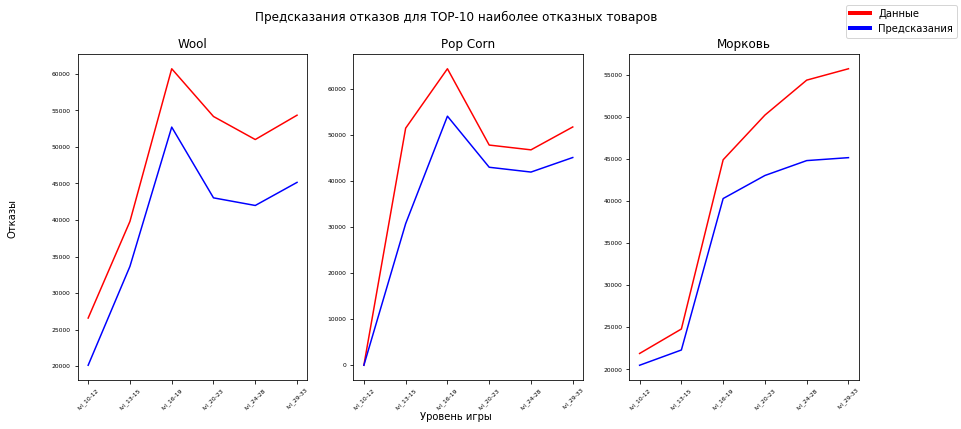

In [160]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
fig.text(0.5, 0.04, 'Уровень игры', ha='center', va='center')
fig.text(0.06, 0.5, 'Отказы', ha='center', va='center', rotation='vertical')
plt.suptitle('Предсказания отказов для TOP-10 наиболее отказных товаров')

legend_lines = [Line2D([0], [0], color=plt.cm.bwr(1000), lw=4),
                Line2D([0], [0], color=plt.cm.bwr(0), lw=4)]
plt.figlegend(legend_lines, ['Данные', 'Предсказания'])

for i in range(len(test_ids)):
    id = test_ids[i]
    X_test = full_df.loc[id, feat_cols].values.reshape(1, -1)
    y_test = full_df.loc[id, lvl_cols]
    y_pred = []
    for lvl_col in lvl_cols:
        y_prev = estimators[lvl_col].predict(X_test)
        X_test = np.concatenate([X_test, y_prev.reshape((-1, 1))], axis=1)
        y_pred.append(y_prev)

    ax = axes[i]
    ax.plot(lvl_cols, y_test, 'r', lvl_cols, y_pred, 'b')
    ax.set_title(full_df.loc[id, 'Название'])
    ax.tick_params(axis='both', labelsize=6)
    ax.tick_params(axis='x', rotation=45)
    
plt.show()

Видно, что модель неплохо угадывает общий тренд, но слишком проста, чтобы давать хорошие количественные предсказания

# 5. Выводы

Построены TOP-10 отказных продуктов как по сумме отказов, так и по отказам на каждом диапазоне уровней:

**'Wool', 'Pop Corn', 'Морковь', 'Paper', 'Shirt', 'Egg', 'Кукуруза', 'Bread', 'Cheese', 'Хлопок'**

и

**'Wool', 'Pop Corn', 'Морковь', 'Paper', 'Кукуруза', 'Cream', 'Sugar', 'Egg', 'Granola', 'Yarn'**

соответственно.

Первые 4 из них - общие; их естесственно считать наиболее отказными:

1. **'Wool'**
2. **'Pop Corn'**
3. **'Морковь'**
4. **'Paper'**

Все эти продукты статистически значимо ниже по цене (покупки и продажи) и времени производства.
Причины, по которым игроки отказываются именно от них, по-видимому, связаны с балансом игровой механики: 

1. Цена отражает общую ценность товара, и за заказы с более ценными товарами дают больше опыта и денег. Выполнение заказов с более ценными товарами оказывается экономически более выгодными, чем трата времени и средств на производство дешевых товаров, даже если это быстрее.

2. С ростом уровня игры производство дешевых низкоуровневых товаров становится не самоцелью для непосредственного удовлетворения заказов, а скорее средством для производства более высокоуровневых товаров